<a href="https://colab.research.google.com/github/sethcoast/attention/blob/main/attention_is_all_you_need.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# what does the architecture look like?

# How has Pytorch changed in the last little while?

# What do I need for all of this?
# 1. Training data
# 2. Model
# 3. Training loop

# This will likely be done in a few separate phases
# 1. Build and validate the model architecture
        # training data?
# 2. Set up training/snapshotting system in GCP


In [3]:
# Import the shit
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.transforms

import numpy as np
import matplotlib.pyplot as plt


# Data

In [4]:
!ls drive/MyDrive/data/ja-en/

en_bpe.txt  jp_bpe.txt	test  test_bpe.json


In [5]:
import json

In [6]:
file_path = 'drive/MyDrive/data/ja-en/'
with open(file_path + 'en_bpe.txt', 'r') as file:
    en_data = json.loads(json.load(file))
with open(file_path + 'jp_bpe.txt', 'r') as file:
    jp_data = json.loads(json.load(file))

In [7]:
print(len(en_data))
print(len(jp_data))

2000
2000


In [8]:
print(en_data[0])
print(jp_data[0])

[103, 8, 1802, 1012, 828, 20, 801]
[3, 422, 887, 162, 183, 1481, 27]


# Model

In [9]:
# Import the shit
import torch
import torch.nn as nn
import torch.utils.data


# Feed forward block (sublayer)
class FeedForwardBlock(nn.Module):
    def __init__(self, dmodel):
        super(FeedForwardBlock, self).__init__()
        # Define the feed forward network layers
        self.fc1 = nn.Linear(dmodel, dmodel)
        self.fc2 = nn.Linear(dmodel, dmodel)
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU(inplace=True) # inplace = True to save memory

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.dropout(x)

        return x

# Multihead Attention block (Sublayer)
class MultiheadAttentionBlock(nn.Module):
    def __init__(self, dmodel, mask=False):
        super(MultiheadAttentionBlock, self).__init__()
        self.mhAtt = nn.MultiheadAttention(dmodel, 8, dropout=0.1, batch_first=True)
        # look-ahead mask
        # self.att_mask = self.create_look_ahead_mask()

    def forward(self, Q, K, V):
        # print(Q.shape, K.shape, V.shape)
        x = self.mhAtt(query=Q, key=K, value=V, need_weights=False)
        return x[0]

    def create_look_ahead_mask(self, size):
        # todo: double check that this is correct
        mask = torch.triu(torch.ones(size, size), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask

# define the encoder model
class EncoderLayer(nn.Module):
    def __init__(self, dmodel):
        super(EncoderLayer, self).__init__()
        # Define the attention layer
        self.mhaBlock = MultiheadAttentionBlock(dmodel)
        self.ff = FeedForwardBlock(dmodel)
        self.norm = nn.LayerNorm(dmodel)


    def forward(self, x):
        # Multi Head Attention Sublayer()
        out = self.mhaBlock(x, x, x)
        out += x # residual connection
        out = self.norm(out) # normalization

        # Feed Forward Sublayer()
        out2 = self.ff(out)
        out2 += out # residual connection
        out2 = self.norm(out2) # normalization

        return out2

# Decoder Layer
class DecoderLayer(nn.Module):
    def __init__(self, dmodel):
        super(DecoderLayer, self).__init__()
        self.mhaBlock1 = MultiheadAttentionBlock(dmodel, mask=True)
        self.ffBlock = FeedForwardBlock(dmodel)
        self.mhaBlock2 = MultiheadAttentionBlock(dmodel)
        self.norm = nn.LayerNorm(dmodel)

    def forward(self, in_encoding, out_embedding):
        ## Multi Head Attention Sublayer 1 (masked)
        # todo: padding mask?
        decoded = self.mhaBlock1(out_embedding, out_embedding, out_embedding)
        decoded += out_embedding # residual connection
        decoded = self.norm(decoded) # normalization
        ## Multi Head Attention Sublayer 2
        decoded2 = self.mhaBlock1(decoded, in_encoding, in_encoding)
        decoded2 += decoded # residual connection
        decoded2 = self.norm(decoded2) # normalization
        ## Feed Forward Sublayer
        decoded3 = self.ffBlock(decoded2)
        decoded3 += decoded2 # residual connection
        decoded3 = self.norm(decoded3) # normalization

        return decoded3


class TransformerNet(nn.Module):
    # numLayers = 6 by default to mimic the parameters of the paper
    def __init__(self, vocab_size, dmodel, numLayers = 6):
        super(TransformerNet, self).__init__()
        # todo: define the positional encoding stuff?
        # Embedding layer
        self.embedding_layer = nn.Linear(vocab_size, dmodel)
        # Instantiate encoder/decoder layers
        self.encoder_layers = nn.ModuleList()
        for _ in range(numLayers):
            self.encoder_layers.append(EncoderLayer(dmodel))
        self.decoder_layers = nn.ModuleList()
        for _ in range(numLayers):
            self.decoder_layers.append(DecoderLayer(dmodel))
        # Output layer
        self.last = nn.Linear(dmodel, vocab_size)
        self.last.weight = torch.nn.Parameter(self.embedding_layer.weight.t()) # todo: double check this
        self.softmax = nn.Softmax(dim=2)

    # todo: maybe rewrite this eventually
    def forward(self, in_seq, out_seq):
        # todo: Embedding layers (multiply weights by √dmodel (v2))
        # todo: Contatenate input w/ positional encoding (v2)
        # Encoder stack
        in_encode = self.embedding_layer(in_seq) # shape = (batch_size, seq_len, dmodel)
        for layer in self.encoder_layers:
            in_encode = layer(in_encode)
        # Decoder stack
        out_encode = self.embedding_layer(out_seq)
        for layer in self.decoder_layers:
            out_encode = layer(in_encode, out_encode)
        # Output layer
        out = self.last(out_encode)
        out = self.softmax(out)

        return out

    def translate(self, src, max_len=50):
        self.eval()  # Set the model to evaluation mode
        src = torch.tensor(src).unsqueeze(0)  # Source sentence tensor



# Dataset

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchtext
import torchvision
import torchvision.transforms
import json

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

In [11]:
class SentenceDataset(Dataset):
    def __init__(self, data_path, vocab_size):
        # read the data
        with open(data_path, 'r') as file:
            self.data = json.loads(json.load(file))

        # split sequences and one-hot encode
        self.input = [nn.functional.one_hot(torch.tensor(sublist[0]), vocab_size).float() for sublist in self.data]
        self.output = [nn.functional.one_hot(torch.tensor(sublist[1]), vocab_size).float() for sublist in self.data]



    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # return the input and output sequences
        return self.input[idx], self.output[idx]

def custom_collate_fn(batch):
    # Sort the batch in the descending order of sequence length
    batch.sort(key=lambda x: len(x), reverse=True)

    # Separate the sequences and labels (if any) # todo: this seems unecessary, remove
    sequences = [item[0] for item in batch]

    # Pad sequences
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)

    return padded_sequences

# Train Loop

In [12]:
from tqdm import tqdm

In [13]:
# Set seeds
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [14]:
# Data loading
# sort sentences by length (todo: do this in prepare_data.py when you write the sentences to file)
# apply transforms as necessary (pad here?)
vocab_size = 2000
drive_dir = 'drive/MyDrive/'
data_dir = 'drive/MyDrive/data/ja-en/'
split_suffix = 'test'
train_data = SentenceDataset(data_dir + split_suffix + '_bpe.json', vocab_size)

# Move pytorch dataset into dataloader.
train_batch_size = 1
train_loader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
print(f'Created `train_loader` with {len(train_loader)} batches!')

Created `train_loader` with 2000 batches!


In [15]:
# Model, Loss Function, Optimizer
dmodel = 512
H = 6
model = TransformerNet(vocab_size, dmodel, H)
criterion = nn.CrossEntropyLoss()  # todo: I'm pretty sure this is correct, but double check
optimizer = optim.Adam(model.parameters(), lr=0.001) # todo: double check paper params

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)


cuda


In [16]:
train_losses = []
val_losses = []

validation_accs = []
accuracies = []

In [17]:
# Training Loop
num_epochs = 5  # Example number of epochs
for epoch in range(num_epochs):
    loop = tqdm(total=len(train_loader), position=0, leave=False)
    model.train()  # Set the model to training mode
    for batch_idx, (input_seq, output_seq) in enumerate(train_loader):
        input_seq, output_seq = input_seq.to(device), output_seq.to(device)

        # Forward pass
        outputs = model(input_seq, output_seq)
        # print(outputs.shape)
        # print(outputs)
        # print(outputs[0][0].shape)
        # print(outputs[0][0].sum())
        # break

        loss = criterion(outputs, output_seq)

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear gradients from the previous step
        loss.backward()  # Backpropagation
        optimizer.step()  # Apply the gradients



        # if (batch_idx + 1) % 100 == 0:
        #     print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        # Housekeeping
        train_losses.append(loss)
        # accuracy = get_raw_accuracy(y_hat, y_truth)
        mem = torch.cuda.memory_allocated(0) / 1e9
        # accuracies.append(accuracy)
        # loop.set_description('epoch:{}, loss:{:.4f}, accuracy:{:.3f}, mem:{:.2f}'.format(epoch, loss, accuracy, mem))
        loop.set_description('epoch:{}, loss:{:.4f}, mem:{:.2f}'.format(epoch, loss, mem))
        loop.update(1)

    # Validation Loop (cute and optimized)
    # compute the loss for all x, y in val_loader, then get the mean of those losses
    # val = np.mean([criterion(model(x.cuda()), y.cuda().long()).item()
    #                 for x, y in test_loader
    #                 ])
    # val_losses.append((len(train_losses), val))
    # print('\nVal Loss: {:.4f}'.format(val))

    # todo: remove accuracy block?
    # val_acc = np.mean([get_raw_accuracy(model(x.cuda()), y.cuda().long())
    #                 for x, y in test_loader
    #                 ])
    # validation_accs.append((len(accuracies), val_acc))
    # print('\nVal Loss: {:.4f}, Val Accuracy: {:.3f}'.format(val, val_acc))

    loop.close()

    # break

print("Training Complete")

epoch:0, loss:0.0054, mem:0.38:   5%|▌         | 105/2000 [00:04<00:59, 31.68it/s]

Epoch [1/5], Step [100/2000], Loss: 0.0167


epoch:0, loss:0.0203, mem:0.38:  10%|█         | 204/2000 [00:07<01:01, 29.01it/s]

Epoch [1/5], Step [200/2000], Loss: 0.0222


epoch:0, loss:0.0222, mem:0.38:  15%|█▌        | 306/2000 [00:11<00:54, 31.18it/s]

Epoch [1/5], Step [300/2000], Loss: 0.0185


epoch:0, loss:0.0028, mem:0.38:  20%|██        | 405/2000 [00:14<00:53, 30.01it/s]

Epoch [1/5], Step [400/2000], Loss: 0.0115


epoch:0, loss:0.0132, mem:0.38:  25%|██▌       | 504/2000 [00:17<00:48, 31.15it/s]

Epoch [1/5], Step [500/2000], Loss: 0.0280


epoch:0, loss:0.0054, mem:0.38:  30%|███       | 605/2000 [00:20<00:45, 30.66it/s]

Epoch [1/5], Step [600/2000], Loss: 0.0167


epoch:0, loss:0.0115, mem:0.38:  35%|███▌      | 705/2000 [00:24<00:42, 30.56it/s]

Epoch [1/5], Step [700/2000], Loss: 0.0115


epoch:0, loss:0.0149, mem:0.38:  40%|████      | 804/2000 [00:27<00:42, 27.82it/s]

Epoch [1/5], Step [800/2000], Loss: 0.0222


epoch:0, loss:0.0083, mem:0.38:  45%|████▌     | 905/2000 [00:30<00:35, 31.04it/s]

Epoch [1/5], Step [900/2000], Loss: 0.0068


epoch:0, loss:0.0185, mem:0.38:  50%|█████     | 1006/2000 [00:34<00:31, 32.02it/s]

Epoch [1/5], Step [1000/2000], Loss: 0.0068


epoch:0, loss:0.0068, mem:0.38:  55%|█████▌    | 1106/2000 [00:37<00:29, 30.36it/s]

Epoch [1/5], Step [1100/2000], Loss: 0.0185


epoch:0, loss:0.0149, mem:0.38:  60%|██████    | 1205/2000 [00:40<00:25, 31.77it/s]

Epoch [1/5], Step [1200/2000], Loss: 0.0467


epoch:0, loss:0.0054, mem:0.38:  65%|██████▌   | 1305/2000 [00:44<00:23, 29.72it/s]

Epoch [1/5], Step [1300/2000], Loss: 0.0083


epoch:0, loss:0.0099, mem:0.38:  70%|███████   | 1404/2000 [00:47<00:21, 27.64it/s]

Epoch [1/5], Step [1400/2000], Loss: 0.0280


epoch:0, loss:0.0054, mem:0.38:  75%|███████▌  | 1504/2000 [00:51<00:16, 29.78it/s]

Epoch [1/5], Step [1500/2000], Loss: 0.0203


epoch:0, loss:0.0222, mem:0.38:  80%|████████  | 1605/2000 [00:54<00:12, 31.68it/s]

Epoch [1/5], Step [1600/2000], Loss: 0.0203


epoch:0, loss:0.0068, mem:0.38:  85%|████████▌ | 1705/2000 [00:57<00:09, 31.30it/s]

Epoch [1/5], Step [1700/2000], Loss: 0.0028


epoch:0, loss:0.0083, mem:0.38:  90%|█████████ | 1805/2000 [01:01<00:06, 30.03it/s]

Epoch [1/5], Step [1800/2000], Loss: 0.0054


epoch:0, loss:0.0028, mem:0.38:  95%|█████████▌| 1904/2000 [01:04<00:03, 29.14it/s]

Epoch [1/5], Step [1900/2000], Loss: 0.0185


Epoch [1/5], Step [2000/2000], Loss: 0.0040


epoch:1, loss:0.0099, mem:0.38:   5%|▌         | 105/2000 [00:03<01:03, 29.69it/s]

Epoch [2/5], Step [100/2000], Loss: 0.0467


epoch:1, loss:0.0132, mem:0.38:  10%|█         | 205/2000 [00:06<00:58, 30.50it/s]

Epoch [2/5], Step [200/2000], Loss: 0.0300


epoch:1, loss:0.0115, mem:0.38:  15%|█▌        | 305/2000 [00:10<00:53, 31.59it/s]

Epoch [2/5], Step [300/2000], Loss: 0.0054


epoch:1, loss:0.0185, mem:0.38:  20%|██        | 405/2000 [00:13<00:50, 31.65it/s]

Epoch [2/5], Step [400/2000], Loss: 0.0068


epoch:1, loss:0.0068, mem:0.38:  25%|██▌       | 505/2000 [00:16<00:52, 28.71it/s]

Epoch [2/5], Step [500/2000], Loss: 0.0132


epoch:1, loss:0.0488, mem:0.38:  30%|███       | 605/2000 [00:20<00:43, 32.15it/s]

Epoch [2/5], Step [600/2000], Loss: 0.0054


epoch:1, loss:0.0203, mem:0.38:  35%|███▌      | 705/2000 [00:23<00:41, 30.88it/s]

Epoch [2/5], Step [700/2000], Loss: 0.0222


epoch:1, loss:0.0083, mem:0.38:  40%|████      | 804/2000 [00:26<00:39, 30.05it/s]

Epoch [2/5], Step [800/2000], Loss: 0.0381


epoch:1, loss:0.0185, mem:0.38:  45%|████▌     | 905/2000 [00:30<00:38, 28.78it/s]

Epoch [2/5], Step [900/2000], Loss: 0.0115


epoch:1, loss:0.0083, mem:0.38:  50%|█████     | 1005/2000 [00:33<00:33, 30.13it/s]

Epoch [2/5], Step [1000/2000], Loss: 0.0185


epoch:1, loss:0.0040, mem:0.38:  55%|█████▌    | 1106/2000 [00:36<00:29, 30.52it/s]

Epoch [2/5], Step [1100/2000], Loss: 0.0467


epoch:1, loss:0.0149, mem:0.38:  60%|██████    | 1205/2000 [00:40<00:27, 28.73it/s]

Epoch [2/5], Step [1200/2000], Loss: 0.0068


epoch:1, loss:0.0222, mem:0.38:  65%|██████▌   | 1304/2000 [00:43<00:25, 27.20it/s]

Epoch [2/5], Step [1300/2000], Loss: 0.0241


epoch:1, loss:0.0203, mem:0.38:  70%|███████   | 1405/2000 [00:46<00:18, 31.79it/s]

Epoch [2/5], Step [1400/2000], Loss: 0.0028


epoch:1, loss:0.0222, mem:0.38:  75%|███████▌  | 1504/2000 [00:50<00:16, 29.57it/s]

Epoch [2/5], Step [1500/2000], Loss: 0.0040


epoch:1, loss:0.0132, mem:0.38:  80%|████████  | 1605/2000 [00:53<00:12, 31.04it/s]

Epoch [2/5], Step [1600/2000], Loss: 0.0068


epoch:1, loss:0.0424, mem:0.38:  85%|████████▌ | 1704/2000 [00:56<00:09, 30.52it/s]

Epoch [2/5], Step [1700/2000], Loss: 0.0040


epoch:1, loss:0.0115, mem:0.38:  90%|█████████ | 1805/2000 [01:00<00:06, 29.64it/s]

Epoch [2/5], Step [1800/2000], Loss: 0.0149


epoch:1, loss:0.0132, mem:0.38:  95%|█████████▌| 1905/2000 [01:03<00:03, 30.17it/s]

Epoch [2/5], Step [1900/2000], Loss: 0.0149


Epoch [2/5], Step [2000/2000], Loss: 0.0068


epoch:2, loss:0.0149, mem:0.38:   5%|▌         | 104/2000 [00:03<01:04, 29.43it/s]

Epoch [3/5], Step [100/2000], Loss: 0.0054


epoch:2, loss:0.0167, mem:0.38:  10%|█         | 204/2000 [00:06<01:01, 29.15it/s]

Epoch [3/5], Step [200/2000], Loss: 0.0054


epoch:2, loss:0.0340, mem:0.38:  15%|█▌        | 306/2000 [00:10<00:54, 31.13it/s]

Epoch [3/5], Step [300/2000], Loss: 0.0167


epoch:2, loss:0.0068, mem:0.38:  20%|██        | 405/2000 [00:13<00:51, 31.16it/s]

Epoch [3/5], Step [400/2000], Loss: 0.0340


epoch:2, loss:0.0016, mem:0.38:  25%|██▌       | 505/2000 [00:16<00:52, 28.35it/s]

Epoch [3/5], Step [500/2000], Loss: 0.0099


epoch:2, loss:0.0099, mem:0.38:  30%|███       | 604/2000 [00:20<00:46, 29.72it/s]

Epoch [3/5], Step [600/2000], Loss: 0.0149


epoch:2, loss:0.0167, mem:0.38:  35%|███▌      | 705/2000 [00:23<00:41, 31.40it/s]

Epoch [3/5], Step [700/2000], Loss: 0.0445


epoch:2, loss:0.0028, mem:0.38:  40%|████      | 804/2000 [00:26<00:42, 27.87it/s]

Epoch [3/5], Step [800/2000], Loss: 0.0300


epoch:2, loss:0.0054, mem:0.38:  45%|████▌     | 905/2000 [00:30<00:36, 30.30it/s]

Epoch [3/5], Step [900/2000], Loss: 0.0280


epoch:2, loss:0.0115, mem:0.38:  50%|█████     | 1005/2000 [00:33<00:33, 29.60it/s]

Epoch [3/5], Step [1000/2000], Loss: 0.0241


epoch:2, loss:0.0132, mem:0.38:  55%|█████▌    | 1104/2000 [00:36<00:31, 28.08it/s]

Epoch [3/5], Step [1100/2000], Loss: 0.0028


epoch:2, loss:0.0040, mem:0.38:  60%|██████    | 1206/2000 [00:40<00:26, 30.19it/s]

Epoch [3/5], Step [1200/2000], Loss: 0.0007


epoch:2, loss:0.0260, mem:0.38:  65%|██████▌   | 1304/2000 [00:43<00:24, 28.56it/s]

Epoch [3/5], Step [1300/2000], Loss: 0.0167


epoch:2, loss:0.0149, mem:0.38:  70%|███████   | 1405/2000 [00:46<00:19, 31.00it/s]

Epoch [3/5], Step [1400/2000], Loss: 0.0115


epoch:2, loss:0.0260, mem:0.38:  75%|███████▌  | 1506/2000 [00:50<00:16, 30.71it/s]

Epoch [3/5], Step [1500/2000], Loss: 0.0068


epoch:2, loss:0.0083, mem:0.38:  80%|████████  | 1605/2000 [00:53<00:12, 31.24it/s]

Epoch [3/5], Step [1600/2000], Loss: 0.0016


epoch:2, loss:0.0167, mem:0.38:  85%|████████▌ | 1705/2000 [00:56<00:09, 30.33it/s]

Epoch [3/5], Step [1700/2000], Loss: 0.0203


epoch:2, loss:0.0028, mem:0.38:  90%|█████████ | 1804/2000 [01:00<00:06, 29.84it/s]

Epoch [3/5], Step [1800/2000], Loss: 0.0040


epoch:2, loss:0.0222, mem:0.38:  95%|█████████▌| 1906/2000 [01:03<00:03, 30.15it/s]

Epoch [3/5], Step [1900/2000], Loss: 0.0185


Epoch [3/5], Step [2000/2000], Loss: 0.0149


epoch:3, loss:0.0300, mem:0.38:   5%|▌         | 105/2000 [00:03<01:03, 29.63it/s]

Epoch [4/5], Step [100/2000], Loss: 0.0149


epoch:3, loss:0.0068, mem:0.38:  10%|█         | 204/2000 [00:06<01:03, 28.11it/s]

Epoch [4/5], Step [200/2000], Loss: 0.0016


epoch:3, loss:0.0185, mem:0.38:  15%|█▌        | 305/2000 [00:10<00:56, 30.25it/s]

Epoch [4/5], Step [300/2000], Loss: 0.0028


epoch:3, loss:0.0040, mem:0.38:  20%|██        | 405/2000 [00:13<00:51, 30.85it/s]

Epoch [4/5], Step [400/2000], Loss: 0.0320


epoch:3, loss:0.0132, mem:0.38:  25%|██▌       | 504/2000 [00:16<00:52, 28.31it/s]

Epoch [4/5], Step [500/2000], Loss: 0.0016


epoch:3, loss:0.0054, mem:0.38:  30%|███       | 605/2000 [00:20<00:45, 30.56it/s]

Epoch [4/5], Step [600/2000], Loss: 0.0115


epoch:3, loss:0.0068, mem:0.38:  35%|███▌      | 705/2000 [00:23<00:43, 29.57it/s]

Epoch [4/5], Step [700/2000], Loss: 0.0083


epoch:3, loss:0.0340, mem:0.38:  40%|████      | 804/2000 [00:27<00:42, 28.33it/s]

Epoch [4/5], Step [800/2000], Loss: 0.0280


epoch:3, loss:0.0099, mem:0.38:  45%|████▌     | 906/2000 [00:30<00:36, 30.19it/s]

Epoch [4/5], Step [900/2000], Loss: 0.0040


epoch:3, loss:0.0241, mem:0.38:  50%|█████     | 1004/2000 [00:34<00:34, 28.81it/s]

Epoch [4/5], Step [1000/2000], Loss: 0.0280


epoch:3, loss:0.0167, mem:0.38:  55%|█████▌    | 1104/2000 [00:37<00:29, 30.12it/s]

Epoch [4/5], Step [1100/2000], Loss: 0.0028


epoch:3, loss:0.0222, mem:0.38:  60%|██████    | 1205/2000 [00:41<00:27, 29.27it/s]

Epoch [4/5], Step [1200/2000], Loss: 0.0068


epoch:3, loss:0.0132, mem:0.38:  65%|██████▌   | 1305/2000 [00:44<00:23, 29.25it/s]

Epoch [4/5], Step [1300/2000], Loss: 0.0149


epoch:3, loss:0.0167, mem:0.38:  70%|███████   | 1404/2000 [00:48<00:22, 26.79it/s]

Epoch [4/5], Step [1400/2000], Loss: 0.0320


epoch:3, loss:0.0149, mem:0.38:  75%|███████▌  | 1505/2000 [00:51<00:16, 30.03it/s]

Epoch [4/5], Step [1500/2000], Loss: 0.0381


epoch:3, loss:0.0260, mem:0.38:  80%|████████  | 1605/2000 [00:55<00:12, 30.55it/s]

Epoch [4/5], Step [1600/2000], Loss: 0.0510


epoch:3, loss:0.0149, mem:0.38:  85%|████████▌ | 1705/2000 [00:58<00:10, 28.41it/s]

Epoch [4/5], Step [1700/2000], Loss: 0.0040


epoch:3, loss:0.0185, mem:0.38:  90%|█████████ | 1805/2000 [01:01<00:06, 30.12it/s]

Epoch [4/5], Step [1800/2000], Loss: 0.0068


epoch:3, loss:0.0203, mem:0.38:  95%|█████████▌| 1904/2000 [01:05<00:03, 28.25it/s]

Epoch [4/5], Step [1900/2000], Loss: 0.0028


Epoch [4/5], Step [2000/2000], Loss: 0.0115


epoch:4, loss:0.0340, mem:0.38:   5%|▌         | 105/2000 [00:03<01:03, 30.08it/s]

Epoch [5/5], Step [100/2000], Loss: 0.0083


epoch:4, loss:0.0132, mem:0.38:  10%|█         | 204/2000 [00:06<01:02, 28.58it/s]

Epoch [5/5], Step [200/2000], Loss: 0.0467


epoch:4, loss:0.0068, mem:0.38:  15%|█▌        | 305/2000 [00:10<00:54, 30.86it/s]

Epoch [5/5], Step [300/2000], Loss: 0.0099


epoch:4, loss:0.0167, mem:0.38:  20%|██        | 404/2000 [00:13<00:56, 28.08it/s]

Epoch [5/5], Step [400/2000], Loss: 0.0381


epoch:4, loss:0.0040, mem:0.38:  25%|██▌       | 505/2000 [00:17<00:49, 30.06it/s]

Epoch [5/5], Step [500/2000], Loss: 0.0222


epoch:4, loss:0.0028, mem:0.38:  30%|███       | 604/2000 [00:20<00:49, 28.11it/s]

Epoch [5/5], Step [600/2000], Loss: 0.0115


epoch:4, loss:0.0068, mem:0.38:  35%|███▌      | 704/2000 [00:23<00:42, 30.78it/s]

Epoch [5/5], Step [700/2000], Loss: 0.0260


epoch:4, loss:0.0402, mem:0.38:  40%|████      | 805/2000 [00:27<00:40, 29.53it/s]

Epoch [5/5], Step [800/2000], Loss: 0.0132


epoch:4, loss:0.0185, mem:0.38:  45%|████▌     | 904/2000 [00:30<00:38, 28.38it/s]

Epoch [5/5], Step [900/2000], Loss: 0.0203


epoch:4, loss:0.0167, mem:0.38:  50%|█████     | 1004/2000 [00:33<00:32, 30.72it/s]

Epoch [5/5], Step [1000/2000], Loss: 0.0185


epoch:4, loss:0.0381, mem:0.38:  55%|█████▌    | 1105/2000 [00:37<00:31, 28.56it/s]

Epoch [5/5], Step [1100/2000], Loss: 0.0280


epoch:4, loss:0.0241, mem:0.38:  60%|██████    | 1206/2000 [00:40<00:26, 30.17it/s]

Epoch [5/5], Step [1200/2000], Loss: 0.0185


epoch:4, loss:0.0040, mem:0.38:  65%|██████▌   | 1306/2000 [00:44<00:23, 29.59it/s]

Epoch [5/5], Step [1300/2000], Loss: 0.0028


epoch:4, loss:0.0115, mem:0.38:  70%|███████   | 1405/2000 [00:47<00:20, 29.01it/s]

Epoch [5/5], Step [1400/2000], Loss: 0.0068


epoch:4, loss:0.0040, mem:0.38:  75%|███████▌  | 1504/2000 [00:50<00:16, 29.38it/s]

Epoch [5/5], Step [1500/2000], Loss: 0.0068


epoch:4, loss:0.0222, mem:0.38:  80%|████████  | 1604/2000 [00:54<00:13, 28.66it/s]

Epoch [5/5], Step [1600/2000], Loss: 0.0083


epoch:4, loss:0.0300, mem:0.38:  85%|████████▌ | 1705/2000 [00:57<00:10, 29.42it/s]

Epoch [5/5], Step [1700/2000], Loss: 0.0149


epoch:4, loss:0.0040, mem:0.38:  90%|█████████ | 1805/2000 [01:00<00:06, 30.42it/s]

Epoch [5/5], Step [1800/2000], Loss: 0.0241


epoch:4, loss:0.0149, mem:0.38:  95%|█████████▌| 1904/2000 [01:04<00:03, 29.26it/s]

Epoch [5/5], Step [1900/2000], Loss: 0.0099


Epoch [5/5], Step [2000/2000], Loss: 0.0083
Training Complete


In [29]:
train_losses = [loss.cpu().item() for loss in train_losses]

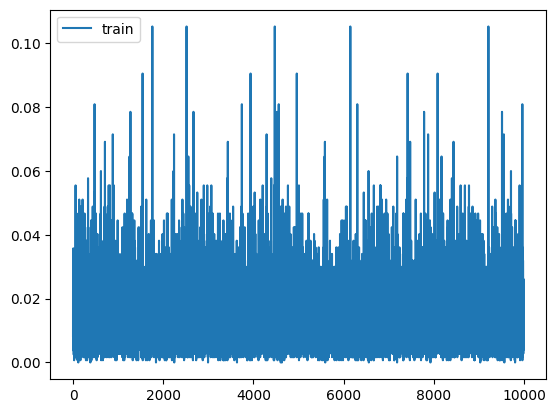

In [30]:
# Show loss curve
# validations is a list of tuples, this unzips it into two lists
# a, b = zip(*val_losses)
plt.plot(train_losses, label='train')
# plt.plot(a, b, label='val')
plt.legend()
plt.show()

In [23]:
# Save the state dictionary
drive_dir = 'drive/MyDrive/'
torch.save(model.state_dict(), drive_dir + 'model/attn.pth')

# Inference

In [26]:
train_data[0]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

In [25]:
# Initialize the model
model = TransformerNet(vocab_size, dmodel)

# Load the saved state dictionary
model.load_state_dict(torch.load('model.pth'))

# Set the model to evaluation mode for inference
model.eval()

TransformerNet(
  (embedding_layer): Linear(in_features=2000, out_features=512, bias=True)
  (encoder_layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (mhaBlock): MultiheadAttentionBlock(
        (mhAtt): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
      )
      (ff): FeedForwardBlock(
        (fc1): Linear(in_features=512, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (relu): ReLU(inplace=True)
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
  )
  (decoder_layers): ModuleList(
    (0-5): 6 x DecoderLayer(
      (mhaBlock1): MultiheadAttentionBlock(
        (mhAtt): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
      )
      (ffBlock): FeedForwardBlock(
        (fc1): Line

In [ ]:
# Decode English sentences
decoded_en = [sp_en.decode(encoded_sentence) for encoded_sentence in encoded_en]

# Decode Japanese sentences
decoded_jp = [sp_jp.decode(encoded_sentence) for encoded_sentence in encoded_jp]